In [1]:
# Imports
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import transforms
import sys
from __future__ import division

### 1. (30pts) Define functions

In [2]:
# One hot Encoding the categorical output values to binary by adding 1's for that index and 0's otherwise
def oneHotEncode(y):
    enc = pd.get_dummies(y['y'])
    return np.matrix(enc)

# Applying Sigmoid Activation function to the hidden layer outputs used while forward propagation
# works with scalar, arrays and matrix as well
# Purpose of this method is to do squishing on the linear function
def sigmoid(z):
    return 1./(1+np.exp(-z))

# Applying Sigmoid Activation function to the hidden layer outputs used while backward propagation to get gradients
# works with scalar, arrays and matrix as well
# Purpose of this method is to do undo the squishing on the linear function
def sigmoid_prime(z):
    inv = (np.exp(-z))/(np.power((1+np.exp(-z)),2))
    return inv

def relu(z):
    return np.maximum(z,0)
    
def relu_prime(z):
    return np.where(z < 0, 0.0, 1.0)

# Get the loss of for the training example
def get_cost(Y, Yhat, lamda, Wl):
    m= Y.shape[1]
    loss = np.multiply(np.log(Yhat),Y) + np.multiply((1.-Y), np.log(1. - Yhat))
    loss = np.sum(loss)
    cost = -1./m * np.sum(loss) + ((lamda/(2*m)) * np.sum(np.square(Wl)))
    cost = np.squeeze(cost)
    return cost

# Forward propagation to calculate yHat by applying activation function twice
def forward_propagate(cache, layerCount, activationFuncs):
    for l in range(1, layerCount+1):
        Zl =  'Z' + str(l)
        Al =  'A' + str(l)
        Wl =  'W' + str(l)
        Al1 = 'A' + str(l-1)
        bl =  'b' + str(l)
        cache[Zl] = np.dot(cache[Wl], cache[Al1]) + cache[bl]
        activationFunc = activationFuncs[l] + '(cache[Zl])'
        cache[Al] = eval(activationFunc)
    return cache

# Backward Propagation function to calculate the gradients
def back_propagate(cache, layerCount, deactivationFuncs):
    gradients = {}
    m = cache['A0'].shape[1]
    for l in xrange(layerCount, 0, -1):
        if(l==layerCount): # is last layer
            dZl = cache['A' + str(l)] - cache['A' + str(l+1)]    
        else:
            Zl = 'Z'+ str(l)
            dZl1 = 'dZ'+str(l+1)
            deacFunc = deactivationFuncs[l] + '(cache[Zl])'
            actv_prime = eval(deacFunc)
            term1 = cache['W'+str(l+1)].T
            term2 = gradients[dZl1]
            product = np.dot( term1, term2)
            dZl = np.multiply(product, actv_prime) 
        gradients['dZ' + str(l)] = dZl
        Al1 = cache['A' + str(l-1)]
#         print('--dZ'+str(l))
#         print(dZl.shape)
#         print('A'+str(l-1))
#         print( Al1.shape)
        dWl = (1./m) * np.dot(dZl, Al1.T)
        dbl = (1./m) * np.sum(dZl, axis=1)
#         print('dW' +str(l))
#         print(dWl.shape)
#         print('db' +str(l))
#         print(dbl.shape)
        gradients['dW' + str(l)] = dWl
        gradients['db' + str(l)] = dbl
    return gradients  


def gradientDescent(X, Y, YOrg, alpha, iters, hiddenLayers, layerSizes, activationFuncs, deactivationFuncs, lamda):  
    
    cache = initialize_parameters(hiddenLayers, layerSizes,activationFuncs )
    cache['A0'] = X
    ykey = 'A' + str(hiddenLayers+1)
    cache[ykey] = Y
    old_cost = sys.maxsize
    new_cost = sys.maxsize
    cost_history = []
    for i in range(iters):
        # Call Forward propagation to calculate yHat
        cache = forward_propagate(cache, hiddenLayers, activationFuncs)
        old_cost = new_cost
        Afinal = cache['A'+str(hiddenLayers)]
        new_cost = get_cost(Y, cache['A'+str(hiddenLayers)], lamda, cache['W'+str(hiddenLayers)]) # Regularization
        gradients = back_propagate(cache, hiddenLayers, deactivationFuncs)
        for l in range(1,hiddenLayers+1):
            Wl = cache['W'+str(l)]
            gradients['dW'+str(l)] = gradients['dW'+str(l)] + (lamda/m) * Wl  # Regularization
            Wl = Wl - alpha * gradients['dW'+str(l)]
            cache['W'+str(l)] = Wl
            bl = cache['b'+str(l)]
            bl = bl - alpha * gradients['db'+str(l)]
            cache['b'+str(l)] = bl
        if(abs(old_cost - new_cost) < 0.00000001):
            print("breaking" + str(old_cost) + str(new_cost))
            break;
        if(i%500 ==0):
            print ("cost : " + str(new_cost) + " Old cost : " + str(old_cost) + " Iteration: " + str(i))
        cost_history.append(new_cost)
    Afinal = softmax(Afinal) # Apply softmax to get the actual labels
    cache['A'+str(hiddenLayers)] = Afinal
    accuracy = get_accuracy(YOrg, Afinal)
    return cache, cost_history, new_cost, accuracy

# Softmax activation function to get the probablity of the classes
def softmax(z):
    softMax = (np.exp(z) / np.sum(np.exp(z),axis=0))
    softMax = np.matrix(np.argmax(softMax,axis=0)).T
    return softMax

def plotCostHistory(cost_history, alpha, i):
     line = plt.plot(cost_history, label=alpha)
     plt.ylabel('Cost');
     plt.xlabel('Iterations');
     plt.title('Cost Progression with Iterations for different learning rates')
     plt.legend()
        
def get_accuracy(Y, Ypred):
    Y = np.matrix(Y)
    numcorrect = 0
    for (x,y) in zip(Ypred,Y):
        if(x[0]==y[0]):
            numcorrect+=1
    accuracy=numcorrect*100.0/len(Y)
    return accuracy

### 2. Split data

In [3]:
# Reading the training data
data_train = pd.read_csv('exam1_train.csv', sep=",", encoding='utf-8', header='infer')
# Remove the un-necessary column
df_train = data_train.drop('Unnamed: 0',axis=1)
m = df_train.shape[0]

y_train = pd.DataFrame(df_train['y'])
X_train = df_train.drop(['y'], axis=1)

X_train_mat = np.matrix(X_train).T
y_train_mat = oneHotEncode(y_train).T

     y
202  4


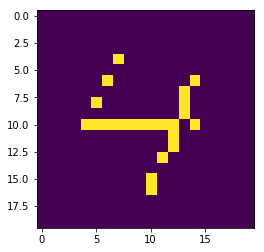

In [4]:
# Reading the test data
data_test = pd.read_csv('exam1_test.csv', sep=",", encoding='utf-8', header='infer')
# Remove the un-necessary column
df_test = data_test.drop('Unnamed: 0',axis=1)

y_test = pd.DataFrame(df_test['y'])
X_test = df_test.drop(['y'], axis=1)

X_test_mat = np.matrix(X_test).T
y_test_mat = oneHotEncode(y_test).T

# Plot the selected pixel
num = 202
pixels = np.array(X_test[num:num+1], dtype='uint8')
print(y_test[num:num+1])
pixels = pixels.reshape((20, 20)).T
plt.imshow(pixels)
plt.show()

### 3. (10pts) Initialize parameters

In [5]:
# Initialize weights // TODO - change the initialization method

np.random.seed(1) # Setting random seed to 1
def initialize_parameters(hiddenLayers, layerSizes, activationFuncs):
    cache = {}
    for l in range(1,hiddenLayers+1):
        #print(l)
        Wl = 'W' + str(l)
        bl = 'b' + str(l)
        #print(layerSizes[l])
        #print(layerSizes[l-1])
        print('activation is ' + str(activationFuncs[l]) + ' for layer ' + str(l))
        if(activationFuncs[l]=='sigmoid'):
            print('activation is sigmoid for layer ' + str(l))
            cache[Wl] =  np.random.randn(layerSizes[l], layerSizes[l-1]) * np.sqrt(2./layerSizes[l-1])
            cache[bl] =  np.zeros((layerSizes[l],1))
        elif(activationFuncs[l]=='relu'):
            print('activation is relu for layer ' + str(l))
            cache[Wl] =  np.random.randn(layerSizes[l], layerSizes[l-1]) * (2./np.sqrt(layerSizes[l-1]))
            cache[bl] =  np.zeros((layerSizes[l],1))
        else:
            print('activation is random for layer ' + str(l))
            cache[Wl] =  np.random.randn(layerSizes[l], layerSizes[l-1]) * 0.01 ## Random
            cache[bl] =  np.zeros((layerSizes[l],1))
        l=l+1
    #print(cache)
    return cache

### 4. (30pts) Deep Neural Network model with more than 2 hidden layers

In [6]:
# Defining Hyperparameters
hiddenLayers = 4
layerSizes = [400, 100, 100, 100, 10] # As specified in assignment requirements, can have as many hidden layers
print(" Number of hidden layers including output layer are - " + str(hiddenLayers))
activationFuncs = ['', 'relu', 'relu', 'relu', 'sigmoid']
deactivationFuncs = ['', 'relu_prime', 'relu_prime', 'relu_prime', 'sigmoid_prime']

 Number of hidden layers including output layer are - 4


In [7]:
# cache = initialize_parameters(hiddenLayers, layerSizes, activationFuncs)
# print(cache['W1'].shape)
# # print(cache['W2'].shape)
# # print(cache['W3'].shape)
# # print(cache['b1'].shape)
# # print(cache['b2'].shape)
# # print(cache['b3'].shape)
# cache['A0'] = X_train_mat
# ykey = 'A' + str(len(layerSizes))
# cache[ykey] = y_train_mat
# cache = forward_propagate(cache, hiddenLayers, ['', 'apply_sigmoid', 'apply_sigmoid','apply_sigmoid'])
# # print(cache['A1'])
# # print(cache['A2'])
# # print(cache['A3'])
# # print(cache['Z2'])

In [8]:
# gradients = back_propagate(cache, hiddenLayers, deactivationFuncs)

### 5. (10pts) Predictions

### 6. (20pts) Optimization

In [9]:
# Optimization function to check cost propagartion for different learning rates
def optimize():
    lamdas = [1.0, 10.0, 100.0, 0.1, 0.01]
    alpha = [1, 0.9, 0.8, 0.5, 0.3, 0.1, 0.05]
    i=0
    scores = pd.DataFrame(columns=['alpha','cache','accuracy', 'lamda'])
    print('*****************Training Data*********************')
    for l in lamdas:
        for a in alpha:
            cache, cost_history, new_cost, acc = gradientDescent(X_train_mat, y_train_mat, y_train, a, 1500, 
                                                hiddenLayers, layerSizes, activationFuncs, deactivationFuncs, l)
            scores.loc[i] = pd.Series({'alpha':a, 'cache': cache, 'accuracy':acc, 'lamda':l})
            print("Cost with " + "Alpha " + str(a) + " and lambda " + str(l) + " is " + str(new_cost) + " & " + "Accuracy is " + str(acc) + " %")
            plotCostHistory(cost_history, a, i)
            i+=1
        least_cost_comb = scores['accuracy'].idxmax()
        alph = scores.iloc[[least_cost_comb]]['alpha'][least_cost_comb]
        cache = scores.iloc[[least_cost_comb]]['cache'][least_cost_comb]
        plt.show()
    return cache, alph,scores

*****************Training Data*********************
activation is relu for layer 1
activation is relu for layer 1
activation is relu for layer 2
activation is relu for layer 2
activation is relu for layer 3
activation is relu for layer 3
activation is sigmoid for layer 4
activation is sigmoid for layer 4
cost : 8.45473491566 Old cost : 9223372036854775807 Iteration: 0


/Users/meenakshiparyani/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/Users/meenakshiparyani/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/Users/meenakshiparyani/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply


cost : 2.34093196812e+22 Old cost : 2.34227021703e+22 Iteration: 500
cost : 1.75908540412e+22 Old cost : 1.76009102674e+22 Iteration: 1000
Cost with Alpha 1 and lambda 1.0is 1.32261444469e+22 & Accuracy is 10.5142857143 %
activation is relu for layer 1
activation is relu for layer 1
activation is relu for layer 2
activation is relu for layer 2
activation is relu for layer 3
activation is relu for layer 3
activation is sigmoid for layer 4
activation is sigmoid for layer 4
cost : 12.0824787109 Old cost : 9223372036854775807 Iteration: 0
cost : 1.76116147373e+28 Old cost : 1.76206756339e+28 Iteration: 500
cost : 1.361786711e+28 Old cost : 1.36248732868e+28 Iteration: 1000
Cost with Alpha 0.9 and lambda 1.0is 1.05351903603e+28 & Accuracy is 10.5142857143 %
activation is relu for layer 1
activation is relu for layer 1
activation is relu for layer 2
activation is relu for layer 2
activation is relu for layer 3
activation is relu for layer 3
activation is sigmoid for layer 4
activation is sig

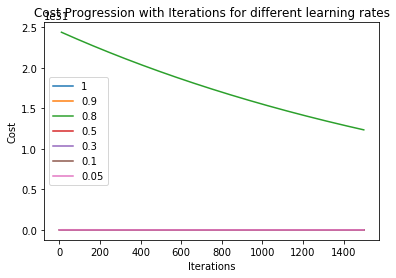

activation is relu for layer 1
activation is relu for layer 1
activation is relu for layer 2
activation is relu for layer 2
activation is relu for layer 3
activation is relu for layer 3
activation is sigmoid for layer 4
activation is sigmoid for layer 4
cost : 6.81270700242 Old cost : 9223372036854775807 Iteration: 0
cost : 9.90039440463e+36 Old cost : 9.95721147254e+36 Iteration: 500
cost : 5.66285061219e+35 Old cost : 5.69534897081e+35 Iteration: 1000
Cost with Alpha 1 and lambda 10.0is 3.25763894728e+34 & Accuracy is 10.5142857143 %
activation is relu for layer 1
activation is relu for layer 1
activation is relu for layer 2
activation is relu for layer 2
activation is relu for layer 3
activation is relu for layer 3
activation is sigmoid for layer 4
activation is sigmoid for layer 4
cost : 10.7573465985 Old cost : 9223372036854775807 Iteration: 0
cost : 7.75903108322e+20 Old cost : 7.79908911489e+20 Iteration: 500
cost : 5.91033306801e+19 Old cost : 5.94084671162e+19 Iteration: 1000


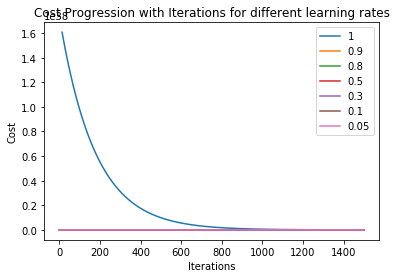

activation is relu for layer 1
activation is relu for layer 1
activation is relu for layer 2
activation is relu for layer 2
activation is relu for layer 3
activation is relu for layer 3
activation is sigmoid for layer 4
activation is sigmoid for layer 4
cost : 6.03995630093 Old cost : 9223372036854775807 Iteration: 0
cost : 448246097.626 Old cost : 475001271.079 Iteration: 500
cost : 3.25046195104 Old cost : 3.25046884201 Iteration: 1000
breaking3.250346677053.2503466672
Cost with Alpha 1 and lambda 100.0is 3.2503466672 & Accuracy is 10.5142857143 %
activation is relu for layer 1
activation is relu for layer 1
activation is relu for layer 2
activation is relu for layer 2
activation is relu for layer 3
activation is relu for layer 3
activation is sigmoid for layer 4
activation is sigmoid for layer 4
cost : 8.3659853191 Old cost : 9223372036854775807 Iteration: 0
cost : 5.49716171986e+47 Old cost : 5.79116373856e+47 Iteration: 500
cost : 2.66976574096e+36 Old cost : 2.81255151975e+36 Ite

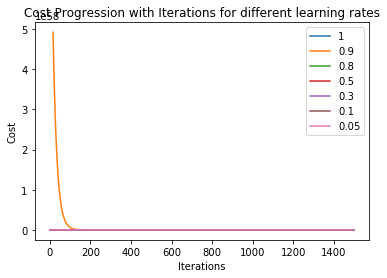

activation is relu for layer 1
activation is relu for layer 1
activation is relu for layer 2
activation is relu for layer 2
activation is relu for layer 3
activation is relu for layer 3
activation is sigmoid for layer 4
activation is sigmoid for layer 4
cost : 8.68405131703 Old cost : 9223372036854775807 Iteration: 0
cost : 1.95623271331e+60 Old cost : 1.95634450283e+60 Iteration: 500
cost : 1.90113048602e+60 Old cost : 1.90123912671e+60 Iteration: 1000
Cost with Alpha 1 and lambda 0.1is 1.84768593246e+60 & Accuracy is 10.5142857143 %
activation is relu for layer 1
activation is relu for layer 1
activation is relu for layer 2
activation is relu for layer 2
activation is relu for layer 3
activation is relu for layer 3
activation is sigmoid for layer 4
activation is sigmoid for layer 4
cost : 9.26592796826 Old cost : 9223372036854775807 Iteration: 0
cost : 1.50181928953e+40 Old cost : 1.50189652893e+40 Iteration: 500
cost : 1.46369288648e+40 Old cost : 1.46376816502e+40 Iteration: 1000
C

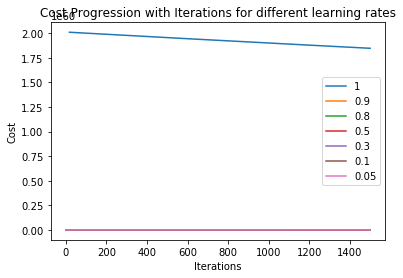

activation is relu for layer 1
activation is relu for layer 1
activation is relu for layer 2
activation is relu for layer 2
activation is relu for layer 3
activation is relu for layer 3
activation is sigmoid for layer 4
activation is sigmoid for layer 4
cost : 8.3499214803 Old cost : 9223372036854775807 Iteration: 0
cost : 1.87744165032e+42 Old cost : 1.8774523786e+42 Iteration: 500
cost : 1.87208517941e+42 Old cost : 1.87209587708e+42 Iteration: 1000
Cost with Alpha 1 and lambda 0.01is 1.86675465804e+42 & Accuracy is 10.5142857143 %
activation is relu for layer 1
activation is relu for layer 1
activation is relu for layer 2
activation is relu for layer 2
activation is relu for layer 3
activation is relu for layer 3
activation is sigmoid for layer 4
activation is sigmoid for layer 4
cost : 11.2331296614 Old cost : 9223372036854775807 Iteration: 0
cost : 1.815195928e+25 Old cost : 1.81520526333e+25 Iteration: 500
cost : 1.81053427146e+25 Old cost : 1.81054358281e+25 Iteration: 1000
Cost

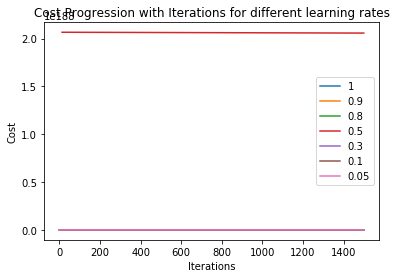

Best alpha is 0.3


In [10]:
# Get the best combination of weights and alpha
cache, alph,scores = optimize()
print('Best alpha is ' + str(alph))

In [11]:
for index, row in scores.iterrows():
    a = row['alpha']
    cache = row['cache']
    lam = row['lamda']
    cache['A0'] = X_test_mat
    ykey = 'A' + str(hiddenLayers+1)
    cache2 = forward_propagate(cache, hiddenLayers, activationFuncs)
    Afinal = softmax(cache2['A'+str(hiddenLayers)])
    acc = get_accuracy(y_test, Afinal)
    print('*****************Test Data************************')
    print('Test Data Optimized accuracy is ' + str(acc) + ' for alpha ' + str(a) + ' and lambda ' + str(lam))

*****************Test Data************************
Test Data Optimized accuracy is 8.8 for alpha 1 and lambda 1.0
*****************Test Data************************
Test Data Optimized accuracy is 8.8 for alpha 0.9 and lambda 1.0
*****************Test Data************************
Test Data Optimized accuracy is 8.8 for alpha 0.8 and lambda 1.0
*****************Test Data************************
Test Data Optimized accuracy is 87.4666666667 for alpha 0.5 and lambda 1.0
*****************Test Data************************
Test Data Optimized accuracy is 92.2 for alpha 0.3 and lambda 1.0
*****************Test Data************************
Test Data Optimized accuracy is 92.7333333333 for alpha 0.1 and lambda 1.0
*****************Test Data************************
Test Data Optimized accuracy is 92.7333333333 for alpha 0.05 and lambda 1.0
*****************Test Data************************
Test Data Optimized accuracy is 8.8 for alpha 1 and lambda 10.0
*****************Test Data*****************